# Full fledge neural net with hyperparameter and droput

In [1]:
import numpy as np 

In [2]:
class DeepNeuralNetwork:
    def __init__(self,input_size,output_size,hidden_size,epoches=1000,learning_rate=0.001,dropout=0.5,hidden_layers=2):
        self.input_size = input_size 
        self.output_size = output_size
        self.hidden_size = hidden_size 
        self.learning_rate = learning_rate 
        self.dropout = dropout 
        self.hidden_layers = hidden_layers 
        self.epoches = epoches

        self.hidden_weights = [np.random.randn(self.input_size,self.hidden_size)]
        self.hidden_bias = [np.zeros((1,self.hidden_size))]

        self.hidden_velocity = [np.zeros_like(self.hidden_weights[0])]
        self.hidden_bias_velocity = [np.zeros((1,self.hidden_size))]
        
        for _ in range(self.hidden_layers): 
            self.hidden_weights.append(np.random.randn(self.hidden_size,self.hidden_size))
            self.hidden_bias.append(np.zeros((1,self.hidden_size)))

            self.hidden_velocity.append(np.zeros((self.hidden_size,self.hidden_size)))
            self.hidden_bias_velocity.append(np.zeros((1,self.hidden_size)))
        
        self.output_weight = np.random.randn(self.hidden_size,self.output_size)
        self.output_bias = np.zeros((1,self.output_size))


        
        self.output_velocity = np.zeros_like(self.output_weight)
        self.output_bias_velocity = np.zeros_like(self.output_bias)


        self.momentum = 0.05

    def SGDM(self,weight_gradient,bias_gradient,layer):
        if weight_gradient.shape[1] == self.hidden_size:
            self.hidden_velocity[layer] = self.momentum * self.hidden_velocity[layer] + self.learning_rate * weight_gradient
            self.hidden_bias_velocity[layer] = self.momentum * self.hidden_bias_velocity[layer] + self.learning_rate * bias_gradient
            return self.hidden_velocity[layer] , self.hidden_bias_velocity[layer]
        else : 
            self.output_velocity = self.momentum * self.output_velocity + self.learning_rate * weight_gradient 
            self.output_bias_velocity = self.momentum * self.output_bias_velocity + self.learning_rate * bias_gradient
            return self.output_velocity, self.output_bias_velocity

    def sigmoid(self,z):
        return (1/(1+np.exp(-z)))
    
    def derivative_sigmoid(self,z):
        s = self.sigmoid(z)
        return s * (1-s)
    
    def Relu(self,z):
        return np.maximum(0,z)

    def derivative_relu(self,z):
        return (z > 0 ).astype(float)
    
    def compute_loss(self,preds,Y):
        preds = np.clip(preds,1e-8,1 - 1e-8) 
        return -np.mean(Y*np.log(preds)+(1-Y)*np.log(1-preds)) 
    
    def Dropout(self, A):
        if self.dropout < 1.0:
            mask = (np.random.rand(*A.shape) < self.dropout).astype(float)
            return (A * mask) / self.dropout
        else:
            return A  
    
    def ForwardPropagation(self,X):
        self.Activations = [X]
        self.hidden_Z = []

        for l in range(self.hidden_layers):
            Z = np.dot(self.Activations[l],self.hidden_weights[l]) + self.hidden_bias[l] 
            self.hidden_Z.append(Z)
            A = self.Relu(Z) 
            self.Activations.append(A)

        self.output_Z = np.dot(self.Activations[-1],self.output_weight) + self.output_bias 
        self.output_A = self.sigmoid(self.output_Z) 
        return self.output_A

    def BackPropagation(self,X,Y):
        m = X.shape[0]
        error = self.output_A - Y 
        Dwo = 1/m * np.dot(self.Activations[-1].T,error)
        Dbo = 1/m * np.sum(error,axis=0,keepdims=True)
        self.output_velocity , self.output_bias_velocity = self.SGDM(Dwo,Dbo,0)
        self.output_weight =  self.output_weight - self.output_velocity
        self.output_bias = self.output_bias - self.output_bias_velocity

        for l in reversed(range(self.hidden_layers)):
            da = np.dot(error,self.output_weight.T if l == self.hidden_layers-1 else self.hidden_weights[l+1].T)
            dz = da * self.derivative_relu(self.hidden_Z[l]) # final errors 

            dw = 1/m * np.dot(self.Activations[l].T,dz)
            db = 1/m * np.sum(dz,axis=0,keepdims=True)
            error = dz 

            self.hidden_velocity[l],self.hidden_bias_velocity[l] = self.SGDM(dw,db,l)
            self.hidden_weights[l] = self.hidden_weights[l] - self.hidden_velocity[l]
            self.hidden_bias[l] = self.hidden_bias[l] - self.hidden_bias_velocity[l]

    def fit(self,X,Y):
        Y = np.array(Y).reshape(-1,1)
        for epoch in range(self.epoches):
            preds_F = self.ForwardPropagation(X)
            loss = self.compute_loss(preds_F, Y)
            print(f"epoch : {epoch+1}, loss : {loss}")
            self.BackPropagation(X,Y)
    def predict(self,X):
        return (self.ForwardPropagation(X) > 0.5).astype(int)


In [3]:
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import pandas as pd 
dataset = pd.read_csv("../BankNote_Authentication.csv")
dataset.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [4]:
Y = np.array(dataset['class']).reshape(-1,1)
X = np.array(dataset.drop(columns=['class']))
X_train,X_test,Y_train,Y_test = train_test_split(X,Y)

print(Y_train.shape)

(1029, 1)


In [5]:
# X  = np.array([[0,0],[0,1],[1,0],[1,1]])
# Y = np.array([0,1,1,1])

model = DeepNeuralNetwork(
    input_size=4,
    output_size=1,
    hidden_size=16,
    epoches=1000,
    learning_rate=0.001,
    dropout=0.8,
    hidden_layers=4
)

model.fit(X_train,Y_train)
preds = model.predict(X_test)

epoch : 1, loss : 10.331558859662119
epoch : 2, loss : 10.56296941594797
epoch : 3, loss : 10.834827786849674
epoch : 4, loss : 11.252534936216401
epoch : 5, loss : 10.044435838331104
epoch : 6, loss : 8.047946605953404
epoch : 7, loss : 7.237385351329654
epoch : 8, loss : 6.839071315781897
epoch : 9, loss : 6.4158435332684585
epoch : 10, loss : 6.015475284620861
epoch : 11, loss : 5.6122861408978295
epoch : 12, loss : 5.049000100128175
epoch : 13, loss : 4.731689580131892
epoch : 14, loss : 4.445126537729477
epoch : 15, loss : 4.094184223092405
epoch : 16, loss : 3.743103982402918
epoch : 17, loss : 3.5263419253388713
epoch : 18, loss : 3.4336782545536253
epoch : 19, loss : 3.303516072462378
epoch : 20, loss : 3.1994854572163947
epoch : 21, loss : 3.0752370409000878
epoch : 22, loss : 2.8581593175776265
epoch : 23, loss : 2.608973295549468
epoch : 24, loss : 2.4251087423500257
epoch : 25, loss : 2.3167560729721797
epoch : 26, loss : 2.236621698802695
epoch : 27, loss : 2.1213328944728

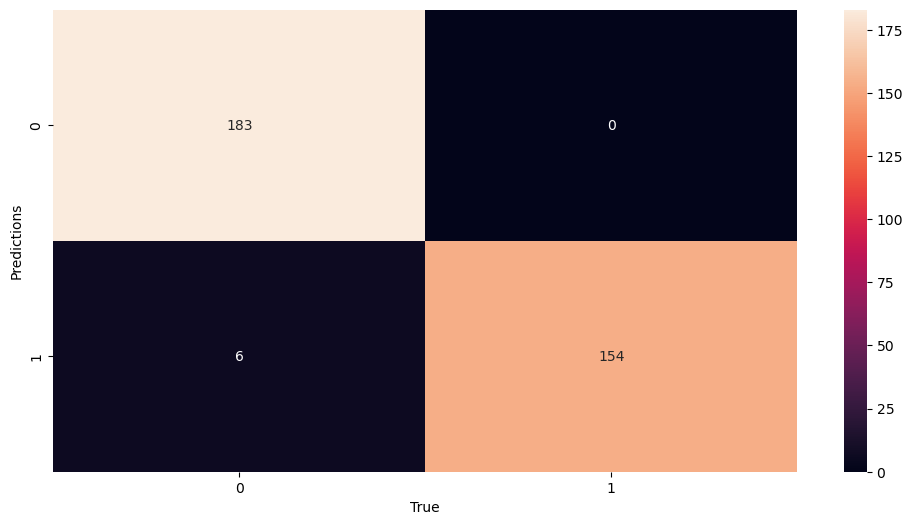

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       183
           1       1.00      0.96      0.98       160

    accuracy                           0.98       343
   macro avg       0.98      0.98      0.98       343
weighted avg       0.98      0.98      0.98       343



In [7]:
from sklearn.metrics import classification_report
cmf = confusion_matrix(Y_test,preds)

plt.figure(figsize=(12,6))
sns.heatmap(cmf,annot=True,fmt='d')
plt.xlabel("True")
plt.ylabel("Predictions")
plt.show()
print(classification_report(Y_test,preds))